<a href="https://colab.research.google.com/github/goddess-1992/mm_idbm/blob/main/mm_bert_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **imports and downloads**

In [12]:
# Ensure kagglehub is installed at the very beginning
!pip install kagglehub

import os
import kagglehub
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import gc # For Python garbage collection
import copy # For deep copying model state_dicts
import matplotlib.pyplot as plt # For plotting
import torchvision.models as models

# --- KaggleHub Dataset Download ---
print("Downloading dataset using kagglehub...")
try:
    download_path = kagglehub.dataset_download("zulkarnainsaurav/imdb-multimodal-vision-and-nlp-genre-classification")
    print("Path to downloaded dataset root:", download_path)

    data_dir = os.path.join(download_path, "IMDB four_genre_posters")
    csv_file = os.path.join(download_path, "IMDB_four_genre_larger_plot_description.csv")

    print(f"Set data_dir to: {data_dir}")
    print(f"Set csv_file to: {csv_file}")

    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Error: Image directory not found at {data_dir}. Please check the path.")

    if not os.path.exists(csv_file):
        raise FileNotFoundError(f"Error: CSV file not found at {csv_file}. Please check the path.")

except Exception as e:
    print(f"An error occurred during dataset download or path configuration: {e}")
    print("Please ensure 'kagglehub' is installed and you have internet access.")
    raise

Path to downloaded dataset root: /kaggle/input/imdb-multimodal-vision-and-nlp-genre-classification
Set data_dir to: /kaggle/input/imdb-multimodal-vision-and-nlp-genre-classification/IMDB four_genre_posters
Set csv_file to: /kaggle/input/imdb-multimodal-vision-and-nlp-genre-classification/IMDB_four_genre_larger_plot_description.csv


# image and dataset **import**

In [13]:


# --- Configuration and Hyperparameters ---
image_size = (84, 84)
max_sequence_length = 375
embedding_dim = 200
DEPTH = 64
L2_REG_LAMBDA = 0.01

# --- Classification Specific Parameter ---
NUM_CLASSES = 4 # Comedy, Horror, Romance, Action

# --- Federated Learning Specific Parameters ---
NUM_CLIENTS = 5
LOCAL_EPOCHS = 5
COMMUNICATION_ROUNDS = 10
BATCH_SIZE = 16 # Adjust lower (e.g., 8, 4, 2) if OOM persists.

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Data Loading and Preprocessing ---
image_descriptions = {}
with open(csv_file, 'r') as csvfile:
    csv_reader = csv.DictReader(csvfile)
    for row in csv_reader:
        title = row['movie_id']
        description = row['description']
        image_descriptions[title] = description

# Define class_to_label globally
classes_list = ['Comedy', 'Horror', 'Romance', 'Action']
label_encoder_global = LabelEncoder()
label_encoder_global.fit(classes_list)
class_to_label = dict(zip(classes_list, label_encoder_global.transform(classes_list)))
print("Global Class to Label Mapping:")
print(class_to_label)

def load_image_pytorch(image_path, target_size=image_size):
    try:
        image = Image.open(image_path).convert('L') # Convert to grayscale
        transform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(), # Converts to [0, 1] and adds channel dimension
        ])
        image_tensor = transform(image)
        return image_tensor
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

def load_data_pytorch(directory):
    data = []
    dataID = []
    labels = []

    for class_name in classes_list: # Use the global list of classes
        path = os.path.join(directory, class_name)
        if not os.path.exists(path):
            print(f"Warning: Class directory not found: {path}. Skipping.")
            continue

        for image_filename in os.listdir(path):
            image_path = os.path.join(path, image_filename)
            image_tensor = load_image_pytorch(image_path)
            title = image_filename.split(".")[0]

            if image_tensor is not None:
                if title in image_descriptions:
                    data.append(image_tensor)
                    dataID.append(title)
                    label = label_encoder_global.transform([class_name])[0] # Use global encoder
                    labels.append(label)
    if not data:
        raise ValueError("No images or descriptions found. Check data paths and file structure.")
    return torch.stack(data), np.array(labels), np.array(dataID)

print("Loading data...")
try:
    data_images, data_labels, data_ids = load_data_pytorch(data_dir)
    print("Data loaded.")
except ValueError as e:
    print(f"Error during data loading: {e}")
    print("Please ensure the dataset is correctly downloaded and unzipped, and paths are correct.")
    raise

print("Processing descriptions...")
all_descriptions = [image_descriptions[id] for id in data_ids]

word_to_idx = {"<pad>": 0}
idx_counter = 1
sequences = []
for desc in all_descriptions:
    tokenized_desc = []
    for word in desc.lower().split():
        if word not in word_to_idx:
            word_to_idx[word] = idx_counter
            idx_counter += 1
        tokenized_desc.append(word_to_idx[word])
    sequences.append(tokenized_desc)

vocab_size = len(word_to_idx)
print("Vocabulary size:", vocab_size)

padded_sequences = np.zeros((len(sequences), max_sequence_length), dtype=int)
for i, seq in enumerate(sequences):
    length = min(len(seq), max_sequence_length)
    padded_sequences[i, :length] = seq[:length]

data_descriptions = torch.tensor(padded_sequences, dtype=torch.long)
print("Descriptions processed.")

print(f"Full image data shape: {data_images.shape}")
print(f"Full description data shape: {data_descriptions.shape}")
print(f"Full labels shape: {data_labels.shape}")

# Dataset split (centralized split for training and global val/test)
dataset_size = len(data_images)
np.random.seed(42) # For reproducibility
train_ratio = 0.8
# Split into training data for clients, and a global holdout set
indices = np.arange(dataset_size)
np.random.shuffle(indices)

train_size = int(dataset_size * train_ratio)
train_indices, global_holdout_indices = indices[:train_size], indices[train_size:]

train_images_all = data_images[train_indices]
train_descriptions_all = data_descriptions[train_indices]
train_labels_all = data_labels[train_indices]

# NEW: Split global_holdout_indices into validation and final test sets
# Let's use 50% for validation and 50% for test from the global_holdout_indices
if len(global_holdout_indices) < 2: # Ensure there are at least two samples to split
    raise ValueError("Not enough global holdout samples to split into validation and test sets.")

val_test_split_ratio = 0.5 # 50% for validation, 50% for test
val_size_global = int(len(global_holdout_indices) * val_test_split_ratio)
np.random.shuffle(global_holdout_indices) # Shuffle before splitting val/test

global_val_indices = global_holdout_indices[:val_size_global]
global_test_indices_final = global_holdout_indices[val_size_global:]

X_val_global = data_images[global_val_indices]
desc_val_global = data_descriptions[global_val_indices]
y_val_global = data_labels[global_val_indices]

X_test_global = data_images[global_test_indices_final]
desc_test_global = data_descriptions[global_test_indices_final]
y_test_global = data_labels[global_test_indices_final]


Using device: cuda
Global Class to Label Mapping:
{'Comedy': np.int64(1), 'Horror': np.int64(2), 'Romance': np.int64(3), 'Action': np.int64(0)}
Loading data...
Data loaded.
Processing descriptions...
Vocabulary size: 32618
Descriptions processed.
Full image data shape: torch.Size([724, 1, 84, 84])
Full description data shape: torch.Size([724, 375])
Full labels shape: (724,)


# **network structure**

In [18]:

# --- REVISED: Standard Classification Dataset ---
class MovieClassificationDataset(Dataset):
    def __init__(self, images, descriptions, labels):
        self.images = images
        self.descriptions = descriptions
        self.labels = labels
        self.num_samples = len(images)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.images[idx], self.descriptions[idx], torch.tensor(self.labels[idx], dtype=torch.long)


# --- ResNet50 Image Encoder ---
class ResNet50ImageEncoder(nn.Module):
    def __init__(self, output_features=64, freeze_pretrained=True):
        super(ResNet50ImageEncoder, self).__init__()
        resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        if freeze_pretrained:
            for param in resnet50.parameters():
                param.requires_grad = False

        self.features = nn.Sequential(*list(resnet50.children())[:-1])
        self.fc_out = nn.Linear(resnet50.fc.in_features, output_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc_out(x)
        x = self.relu(x)
        return x

# --- Modified MultimodalClassificationNetwork ---
class MultimodalClassificationNetwork(nn.Module):
    def __init__(self, input_size, depth, vocab_size, embedding_dim, lstm_hidden_dim=64, num_classes=4):
        super(MultimodalClassificationNetwork, self).__init__()
        self.image_encoder = ResNet50ImageEncoder(output_features=64)
        self.description_encoder = DescriptionEncoderLSTM(vocab_size, embedding_dim, lstm_hidden_dim=64)

        self.fc1 = nn.Linear(64 + 64, 64)
        self.bn = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.dropout_final = nn.Dropout(p=0.5, inplace=False)
        self.output_layer = nn.Linear(64, num_classes)

    def forward(self, img, desc):
        feature_vector_img = self.image_encoder(img)
        feature_vector_desc = self.description_encoder(desc)

        concat_features = torch.cat((feature_vector_img, feature_vector_desc), dim=1)

        x = self.fc1(concat_features)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout_final(x)
        output = self.output_layer(x)
        return output


# ... (other imports and code) ...

# class DescriptionEncoderLSTM(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, lstm_hidden_dim):
#         super(DescriptionEncoderLSTM, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.dropout_emb = nn.Dropout(p=0.2, inplace=False)

#         # --- CHANGE: Use Bidirectional LSTM ---
#         # The lstm_hidden_dim passed to nn.LSTM will be the size of the hidden state
#         # for *one* direction. Since it's bidirectional, the total output will be 2 * hidden_dim.
#         # We want the final output from this encoder to be 64 features.
#         # So, if 2 * internal_lstm_hidden_dim = 64, then internal_lstm_hidden_dim = 32.
#         # We will use 32 as the hidden_dim for nn.LSTM here.
#         # Original code used lstm_hidden_dim=64, but that was for unidirectional.

#         self.lstm = nn.LSTM(embedding_dim, 32, batch_first=True, bidirectional=True, dropout=0.2)
#         # Note: dropout is applied only if num_layers > 1 for PyTorch's nn.LSTM.
#         # If you want multiple layers with dropout between them, you'd add num_layers > 1.

#     def forward(self, x):
#         x = self.embedding(x)
#         x = self.dropout_emb(x)

#         # LSTM returns output, (h_n, c_n)
#         # For BiLSTM, h_n shape is (num_layers * num_directions, batch_size, hidden_size)
#         # num_directions is 2 for bidirectional.
#         _, (hidden, _) = self.lstm(x)

#         # We need to concatenate the hidden states from the two directions (forward and backward)
#         # hidden will have shape (2, batch_size, 32) for num_layers=1
#         # We want to concatenate them to get (batch_size, 64)
#         forward_hidden = hidden[0, :, :]  # Hidden state from forward direction of last layer
#         backward_hidden = hidden[1, :, :] # Hidden state from backward direction of last layer

#         # Concatenate along the last dimension (features)
#         concatenated_hidden = torch.cat((forward_hidden, backward_hidden), dim=1)

#         return concatenated_hidden # This will have shape (batch_size, 64)

# ... (rest of your code) ...

# When initializing MultimodalClassificationNetwork, ensure lstm_hidden_dim is set
# This parameter is now mainly for clarity in the network's __init__ but the
# DescriptionEncoderLSTM itself uses 32 for its internal hidden_size.
# The MultimodalClassificationNetwork's __init__ looks like this:
# class MultimodalClassificationNetwork(nn.Module):
#    def __init__(self, input_size, depth, vocab_size, embedding_dim, lstm_hidden_dim=64, num_classes=4):
#        super(MultimodalClassificationNetwork, self).__init__()
#        self.image_encoder = ResNet50ImageEncoder(output_features=64)
#        self.description_encoder = DescriptionEncoderLSTM(vocab_size, embedding_dim, lstm_hidden_dim=64) # This param is passed but internally LSTM uses 32.
#        # ... rest of the network ...

# So, when instantiating MultimodalClassificationNetwork:
# global_model = MultimodalClassificationNetwork(
#     input_size=image_size[0],
#     depth=DEPTH,
#     vocab_size=vocab_size,
#     embedding_dim=embedding_dim,
#     lstm_hidden_dim=64, # Pass 64 here as the *expected output size* of the encoder
#     num_classes=NUM_CLASSES
# ).to(device)


# --- DescriptionEncoderLSTM ---
class DescriptionEncoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_hidden_dim):
        super(DescriptionEncoderLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout_emb = nn.Dropout(p=0.2, inplace=False)
        self.lstm = nn.LSTM(embedding_dim, 64, batch_first=True, dropout=0.2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout_emb(x)
        _, (hidden, _) = self.lstm(x)
        return hidden.squeeze(0)


## **federated** **learning**

In [19]:

# --- Data Partitioning for Clients ---
print(f"\nPartitioning data for {NUM_CLIENTS} clients...")
all_train_indices = np.arange(len(train_images_all))
client_train_indices = np.array_split(all_train_indices, NUM_CLIENTS)

client_datasets = []
for i, indices in enumerate(client_train_indices):
    client_images_subset = train_images_all[indices]
    client_descriptions_subset = train_descriptions_all[indices]
    client_labels_subset = train_labels_all[indices]

    client_dataset = MovieClassificationDataset(
        client_images_subset,
        client_descriptions_subset,
        client_labels_subset
    )
    client_datasets.append(client_dataset)
    print(f"Client {i+1} has {len(client_dataset)} samples.")

# NEW: Global validation and final test set DataLoaders
global_val_dataset = MovieClassificationDataset(X_val_global, desc_val_global, y_val_global)
global_val_loader = DataLoader(global_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Global Validation set has {len(global_val_dataset)} samples.")

global_test_dataset_final = MovieClassificationDataset(X_test_global, desc_test_global, y_test_global)
global_test_loader_final = DataLoader(global_test_dataset_final, batch_size=BATCH_SIZE, shuffle=False)
print(f"Global Final Test set has {len(global_test_dataset_final)} samples.")


# --- Client Class ---
class Client:
    def __init__(self, client_id, dataset, model_params):
        self.id = client_id
        self.local_model = MultimodalClassificationNetwork(
            input_size=image_size[0],
            depth=DEPTH,
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            lstm_hidden_dim=64,
            num_classes=NUM_CLASSES
        ).to(device)
        self.local_model.load_state_dict(model_params)
        self.data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        self.optimizer = optim.Adam(self.local_model.parameters(), lr=0.001, weight_decay=L2_REG_LAMBDA)
        self.criterion = nn.CrossEntropyLoss()

    def receive_global_model(self, global_model_params):
        self.local_model.load_state_dict(global_model_params)
        self.optimizer = optim.Adam(self.local_model.parameters(), lr=0.001, weight_decay=L2_REG_LAMBDA)

    def train_local(self):
        self.local_model.train()
        max_batches_per_local_epoch = 100 # Adjust this based on client data size and desired local training.

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

        for epoch in range(LOCAL_EPOCHS):
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            num_batches_processed = 0

            for i, (img, desc, labels) in enumerate(self.data_loader):
                if num_batches_processed >= max_batches_per_local_epoch:
                    break

                img, desc, labels = img.to(device), desc.to(device), labels.to(device)

                self.optimizer.zero_grad()
                outputs = self.local_model(img, desc)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
                num_batches_processed += 1

            if total_train > 0:
                epoch_loss = running_loss / total_train
                epoch_acc = correct_train / total_train
                print(f"  Client {self.id} - Local Epoch {epoch+1}/{LOCAL_EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
            else:
                print(f"  Client {self.id} - Local Epoch {epoch+1}/{LOCAL_EPOCHS}, No training data processed for this epoch.")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

        return self.local_model.state_dict(), epoch_loss, epoch_acc

# --- Server Logic (Federated Averaging) ---
def federated_average(client_models_state_dicts):
    if not client_models_state_dicts:
        return None

    avg_state_dict = copy.deepcopy(client_models_state_dicts[0])

    for key in avg_state_dict.keys():
        for i in range(1, len(client_models_state_dicts)):
            avg_state_dict[key] += client_models_state_dicts[i][key]
        avg_state_dict[key] = torch.div(avg_state_dict[key], len(client_models_state_dicts))
    return avg_state_dict

def evaluate_global_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

        max_eval_batches = 100
        num_batches_evaluated = 0

        for img, desc, labels in data_loader:
            if num_batches_evaluated >= max_eval_batches:
                break

            img, desc, labels = img.to(device), desc.to(device), labels.to(device)

            outputs = model(img, desc)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            num_batches_evaluated += 1

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

    if total == 0:
        return 0.0, 0.0

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy



Partitioning data for 5 clients...
Client 1 has 116 samples.
Client 2 has 116 samples.
Client 3 has 116 samples.
Client 4 has 116 samples.
Client 5 has 115 samples.
Global Validation set has 72 samples.
Global Final Test set has 73 samples.


# **train**

In [20]:

# Initialize global model
global_model = MultimodalClassificationNetwork(
    input_size=image_size[0],
    depth=DEPTH,
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    lstm_hidden_dim=64,
    num_classes=NUM_CLASSES
).to(device)

clients = []
for i, dataset in enumerate(client_datasets):
    client = Client(i + 1, dataset, global_model.state_dict())
    clients.append(client)
print(f"Initialized {len(clients)} clients.")

# --- Federated Learning Training Loop ---
print("\n--- Starting Federated Learning Training ---")
best_global_val_loss = float('inf') # Still use validation loss for early stopping / best model saving
global_model_save_path = '/content/best_global_model_pytorch_fl.pth'

# Lists to store metrics for plotting
global_history_val_loss = []
global_history_val_accuracy = []
global_history_test_loss = []
global_history_test_accuracy = []
clients_history_loss = {f'Client {i+1}': [] for i in range(len(client_datasets))}
clients_history_accuracy = {f'Client {i+1}': [] for i in range(len(client_datasets))}


if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

for round_num in range(COMMUNICATION_ROUNDS):
    print(f"\nCommunication Round {round_num + 1}/{COMMUNICATION_ROUNDS}")

    for client in clients:
        client.receive_global_model(global_model.state_dict())

    client_updates = []
    for idx, client in enumerate(clients):
        print(f"  Client {client.id} starting local training...")
        updated_state_dict, local_loss, local_acc = client.train_local()
        client_updates.append(updated_state_dict)
        clients_history_loss[f'Client {client.id}'].append(local_loss)
        clients_history_accuracy[f'Client {client.id}'].append(local_acc)

    print("Aggregating client models...")
    aggregated_state_dict = federated_average(client_updates)
    global_model.load_state_dict(aggregated_state_dict)
    print("Global model updated.")

    # Evaluate global model on Validation set
    val_loss_round, val_acc_round = evaluate_global_model(global_model, global_val_loader, nn.CrossEntropyLoss())
    print(f"Global Model - Validation Loss: {val_loss_round:.4f}, Validation Accuracy: {val_acc_round:.4f}")

    # Evaluate global model on Final Test set
    test_loss_round, test_acc_round = evaluate_global_model(global_model, global_test_loader_final, nn.CrossEntropyLoss())
    print(f"Global Model - Final Test Loss: {test_loss_round:.4f}, Final Test Accuracy: {test_acc_round:.4f}")

    # Store global metrics for plotting
    global_history_val_loss.append(val_loss_round)
    global_history_val_accuracy.append(val_acc_round)
    global_history_test_loss.append(test_loss_round)
    global_history_test_accuracy.append(test_acc_round)

    # Use validation loss for best model saving
    if val_loss_round < best_global_val_loss:
        best_global_val_loss = val_loss_round
        torch.save(global_model.state_dict(), global_model_save_path)
        print(f"Best global model saved with validation loss: {best_global_val_loss:.4f}")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

print("\n--- Federated Learning Training Finished ---")

# --- Final Evaluation (on best saved model) ---
if os.path.exists(global_model_save_path):
    global_model.load_state_dict(torch.load(global_model_save_path))
    print(f"Loaded best global model from {global_model_save_path}")
else:
    print("No best global model saved. Using the last trained global model.")

final_val_loss, final_val_accuracy = evaluate_global_model(global_model, global_val_loader, nn.CrossEntropyLoss())
final_test_loss, final_test_accuracy = evaluate_global_model(global_model, global_test_loader_final, nn.CrossEntropyLoss())
print(f"\nFinal Global Model Performance (Best Model):")
print(f"Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.4f}")







Initialized 5 clients.

--- Starting Federated Learning Training ---

Communication Round 1/10
  Client 1 starting local training...
  Client 1 - Local Epoch 1/5, Loss: 1.4041, Accuracy: 0.3017
  Client 1 - Local Epoch 2/5, Loss: 1.1221, Accuracy: 0.4914
  Client 1 - Local Epoch 3/5, Loss: 1.0157, Accuracy: 0.5862
  Client 1 - Local Epoch 4/5, Loss: 0.8952, Accuracy: 0.6638
  Client 1 - Local Epoch 5/5, Loss: 0.7938, Accuracy: 0.7845
  Client 2 starting local training...
  Client 2 - Local Epoch 1/5, Loss: 1.3513, Accuracy: 0.3793
  Client 2 - Local Epoch 2/5, Loss: 1.1471, Accuracy: 0.5086
  Client 2 - Local Epoch 3/5, Loss: 1.0006, Accuracy: 0.6810
  Client 2 - Local Epoch 4/5, Loss: 0.9319, Accuracy: 0.6810
  Client 2 - Local Epoch 5/5, Loss: 0.8296, Accuracy: 0.7241
  Client 3 starting local training...
  Client 3 - Local Epoch 1/5, Loss: 1.3733, Accuracy: 0.2931
  Client 3 - Local Epoch 2/5, Loss: 1.0760, Accuracy: 0.6034
  Client 3 - Local Epoch 3/5, Loss: 0.9816, Accuracy: 0.620

# **Plots**


--- Generating Plots ---


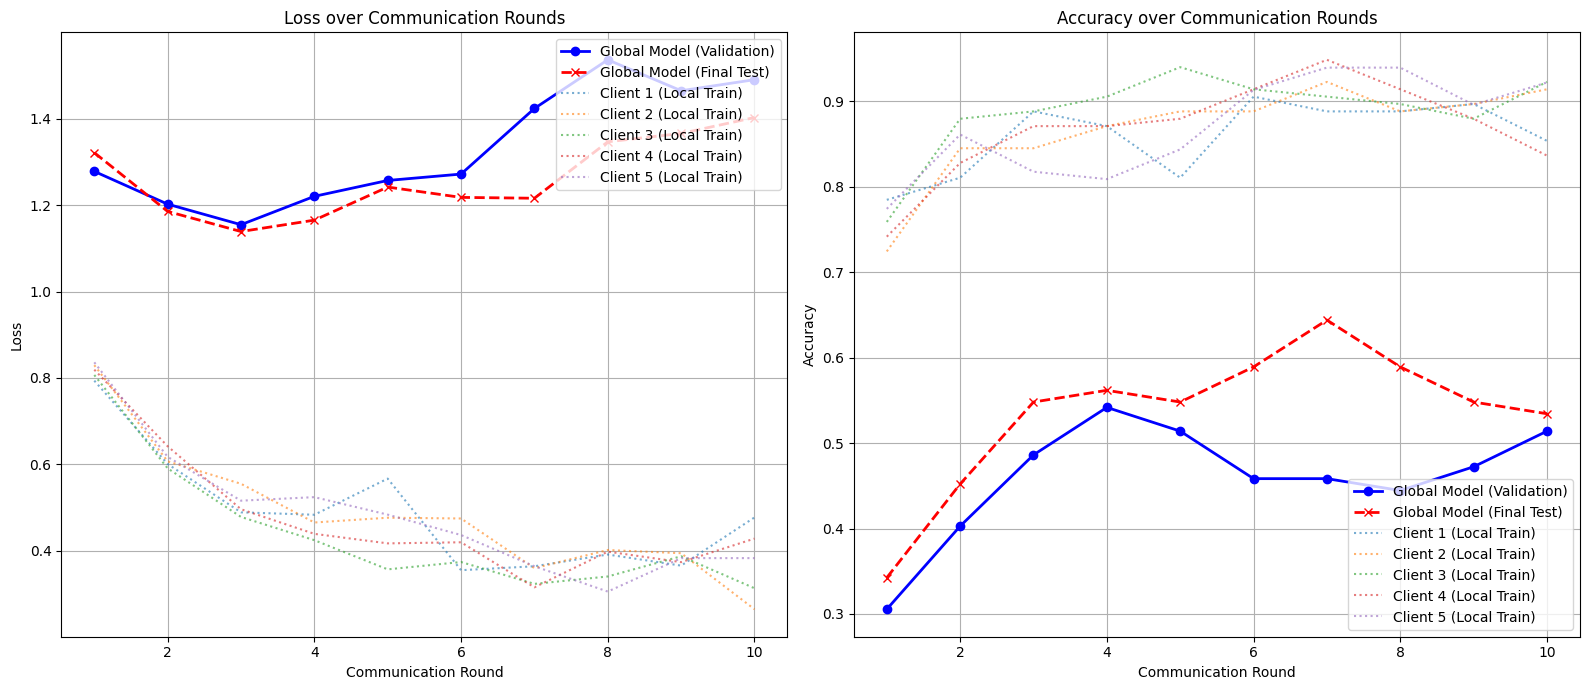


--- Plotting a Sample Prediction Output (Global and Local Models) ---
29


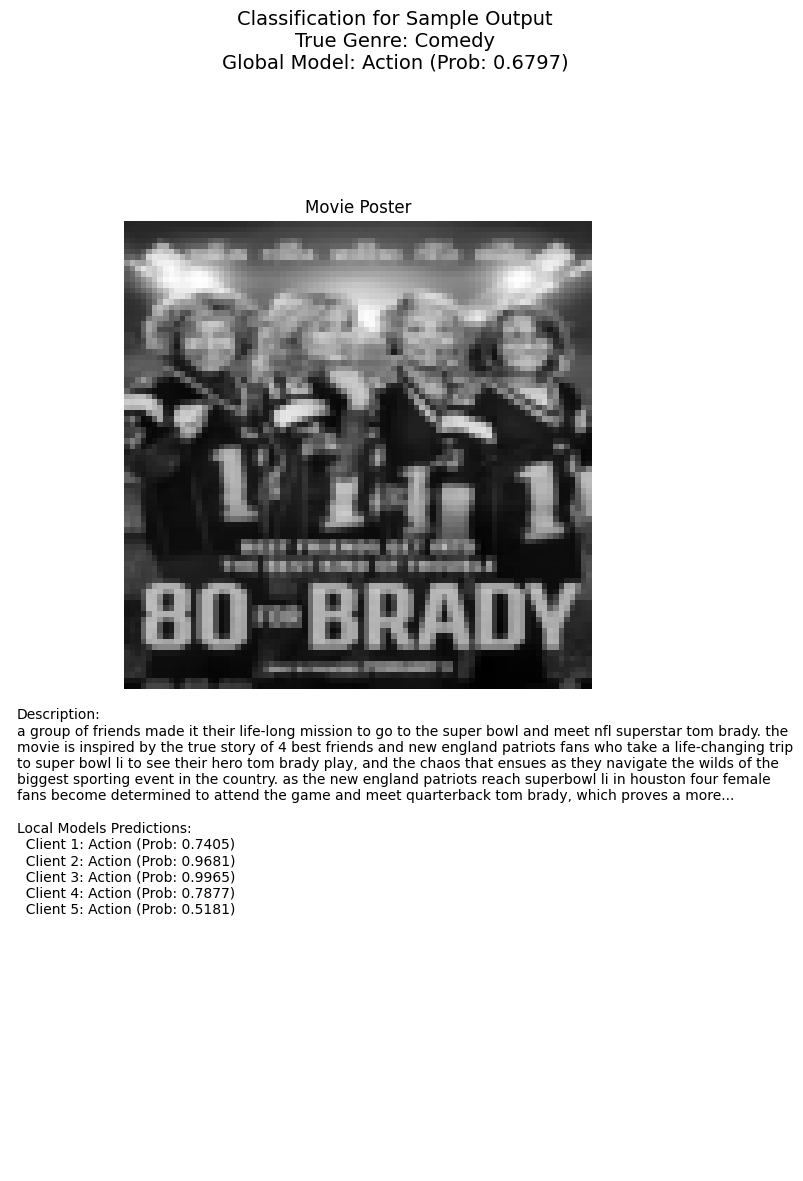

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from PIL import Image
import gc # Import garbage collection if not already
# --- Plotting Training History (Global Val/Test vs Clients Local Train) ---
print("\n--- Generating Plots ---")
rounds = range(1, COMMUNICATION_ROUNDS + 1)

plt.figure(figsize=(16, 7))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(rounds, global_history_val_loss, marker='o', linestyle='-', label='Global Model (Validation)', color='blue', linewidth=2)
plt.plot(rounds, global_history_test_loss, marker='x', linestyle='--', label='Global Model (Final Test)', color='red', linewidth=2)
for client_id, losses in clients_history_loss.items():
    plt.plot(rounds, losses, linestyle=':', alpha=0.6, label=f'{client_id} (Local Train)')
plt.title('Loss over Communication Rounds')
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(rounds, global_history_val_accuracy, marker='o', linestyle='-', label='Global Model (Validation)', color='blue', linewidth=2)
plt.plot(rounds, global_history_test_accuracy, marker='x', linestyle='--', label='Global Model (Final Test)', color='red', linewidth=2)
for client_id, accuracies in clients_history_accuracy.items():
    plt.plot(rounds, accuracies, linestyle=':', alpha=0.6, label=f'{client_id} (Local Train)')
plt.title('Accuracy over Communication Rounds')
plt.xlabel('Communication Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.tight_layout()
plt.show()
print("\n--- Plotting a Sample Prediction Output (Global and Local Models) ---")

if len(X_test_global) < 1:
    print("Not enough global test samples to plot a single prediction. Need at least 1 sample.")
else:
    np.random.seed(47) # For reproducibility of the sample output plot
    idx = np.random.choice(len(X_test_global), 1, replace=False)[0]
    print(idx)
    img_display = X_test_global[idx].squeeze().cpu().numpy()

    desc_words = []
    reverse_word_map = dict(map(reversed, word_to_idx.items()))
    for token_id in desc_test_global[idx].cpu().numpy():
        if token_id == 0:
            break
        if token_id in reverse_word_map:
            desc_words.append(reverse_word_map[token_id])
        else:
            desc_words.append('<unk>')
    desc_full_text = ' '.join(desc_words[:100]) + '...' if len(desc_words) > 100 else ' '.join(desc_words)


    img_model = X_test_global[idx].unsqueeze(0).to(device)
    desc_model = desc_test_global[idx].unsqueeze(0).to(device)

    true_label_id = y_test_global[idx]
    reverse_label_map = dict(map(reversed, class_to_label.items()))
    true_label_text = reverse_label_map.get(true_label_id, 'Unknown')


    # --- Predictions from Global Model ---
    global_model.eval()
    with torch.no_grad():
        outputs_global = global_model(img_model, desc_model)
        predicted_prob_raw_global = torch.softmax(outputs_global, dim=1)
        predicted_prob_value_global, predicted_class_id_global = torch.max(predicted_prob_raw_global, 1)

    predicted_class_text_global = reverse_label_map.get(predicted_class_id_global.item(), 'Unknown')
    predicted_prob_for_class_global = predicted_prob_value_global.item()

    # --- Predictions from Local Models ---
    local_predictions_text = []
    for client_obj in clients: # 'clients' list holds instances of the Client class
        client_model = client_obj.local_model # Access the local model
        client_model.eval() # Set local model to eval mode
        with torch.no_grad():
            outputs_local = client_model(img_model, desc_model)
            predicted_prob_raw_local = torch.softmax(outputs_local, dim=1)
            predicted_prob_value_local, predicted_class_id_local = torch.max(predicted_prob_raw_local, 1)

        predicted_class_text_local = reverse_label_map.get(predicted_class_id_local.item(), 'Unknown')
        predicted_prob_for_class_local = predicted_prob_value_local.item()

        local_predictions_text.append(
            f"  Client {client_obj.id}: {predicted_class_text_local} (Prob: {predicted_prob_for_class_local:.4f})"
        )
        # Clear local model if it's not being used further to free up memory
        # del client_model
        # gc.collect()
        # if torch.cuda.is_available(): torch.cuda.empty_cache()


    # --- Create the Plot ---
    plt.figure(figsize=(8, 12)) # Increased height to accommodate more text

    plt.subplot(2, 1, 1)
    plt.imshow(img_display, cmap='gray')
    plt.title('Movie Poster')
    plt.axis('off')

    # Main title with True Genre and Global Model Prediction
    plt.suptitle(f"Classification for Sample Output\n"
                 f"True Genre: {true_label_text}\n"
                 f"Global Model: {predicted_class_text_global} (Prob: {predicted_prob_for_class_global:.4f})",
                 fontsize=14, y=0.98) # Adjust y to prevent overlap

    # Add text description and local model predictions below the image
    plt.subplot(2, 1, 2)

    # Description text
    desc_display_text = f"Description:\n{desc_full_text}\n\n"

    # Local model predictions text
    local_models_summary = "Local Models Predictions:\n" + "\n".join(local_predictions_text)

    # Combine text for display in the subplot
    full_text_to_display = desc_display_text + local_models_summary

    plt.text(0.01, 0.99, full_text_to_display,
             verticalalignment='top', horizontalalignment='left',
             fontsize=10, wrap=True)
    plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

# The model saving and final print statements would come after this plotting block in your full script.
# torch.save(global_model.state_dict(), '/content/final_global_model_pytorch_fl.pth')
# print("Final global model saved to /content/final_global_model_pytorch_fl.pth")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Processing descriptions with BERT tokenizer...
Descriptions processed with BERT tokenizer.
Tokenized input_ids shape: torch.Size([724, 375])
Attention mask shape: torch.Size([724, 375])
Client 1 has 116 samples.
Client 2 has 116 samples.
Client 3 has 116 samples.
Client 4 has 116 samples.
Client 5 has 115 samples.
Global Validation set has 72 samples.
Global Final Test set has 73 samples.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Initialized 5 clients.

--- Starting Federated Learning Training ---

Communication Round 1/10
  Client 1 starting local training...
  Client 1 - Local Epoch 1/5, Loss: 1.2975, Accuracy: 0.4138
  Client 1 - Local Epoch 2/5, Loss: 1.1974, Accuracy: 0.4914
  Client 1 - Local Epoch 3/5, Loss: 0.9767, Accuracy: 0.6207
  Client 1 - Local Epoch 4/5, Loss: 0.9374, Accuracy: 0.6552
  Client 1 - Local Epoch 5/5, Loss: 0.8107, Accuracy: 0.6897
  Client 2 starting local training...
  Client 2 - Local Epoch 1/5, Loss: 1.4137, Accuracy: 0.3190
  Client 2 - Local Epoch 2/5, Loss: 1.2993, Accuracy: 0.4138
  Client 2 - Local Epoch 3/5, Loss: 1.1340, Accuracy: 0.5259
  Client 2 - Local Epoch 4/5, Loss: 1.0285, Accuracy: 0.5862
  Client 2 - Local Epoch 5/5, Loss: 0.9044, Accuracy: 0.6466
  Client 3 starting local training...
  Client 3 - Local Epoch 1/5, Loss: 1.3530, Accuracy: 0.3707
  Client 3 - Local Epoch 2/5, Loss: 1.1524, Accuracy: 0.5517
  Client 3 - Local Epoch 3/5, Loss: 1.1194, Accuracy: 0.508

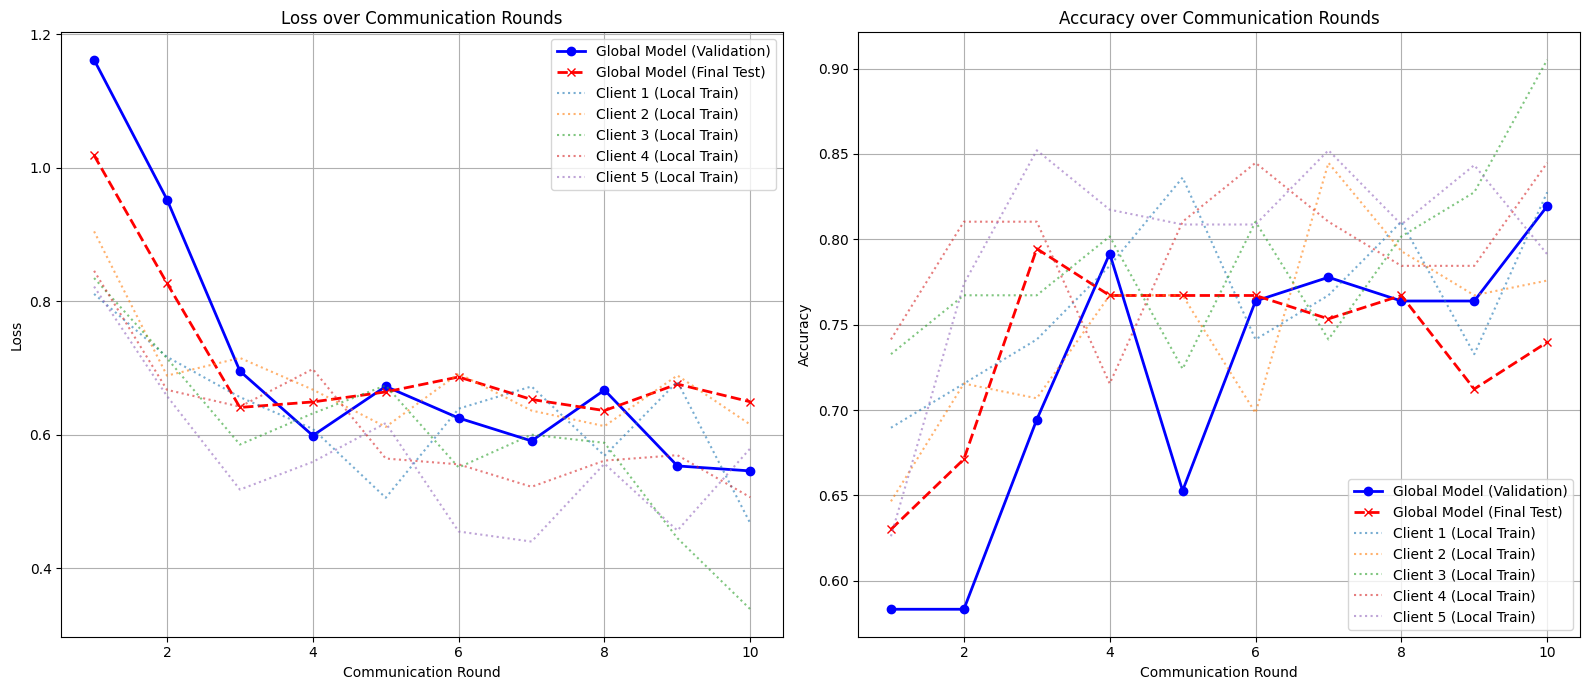


--- Plotting a Sample Prediction Output ---


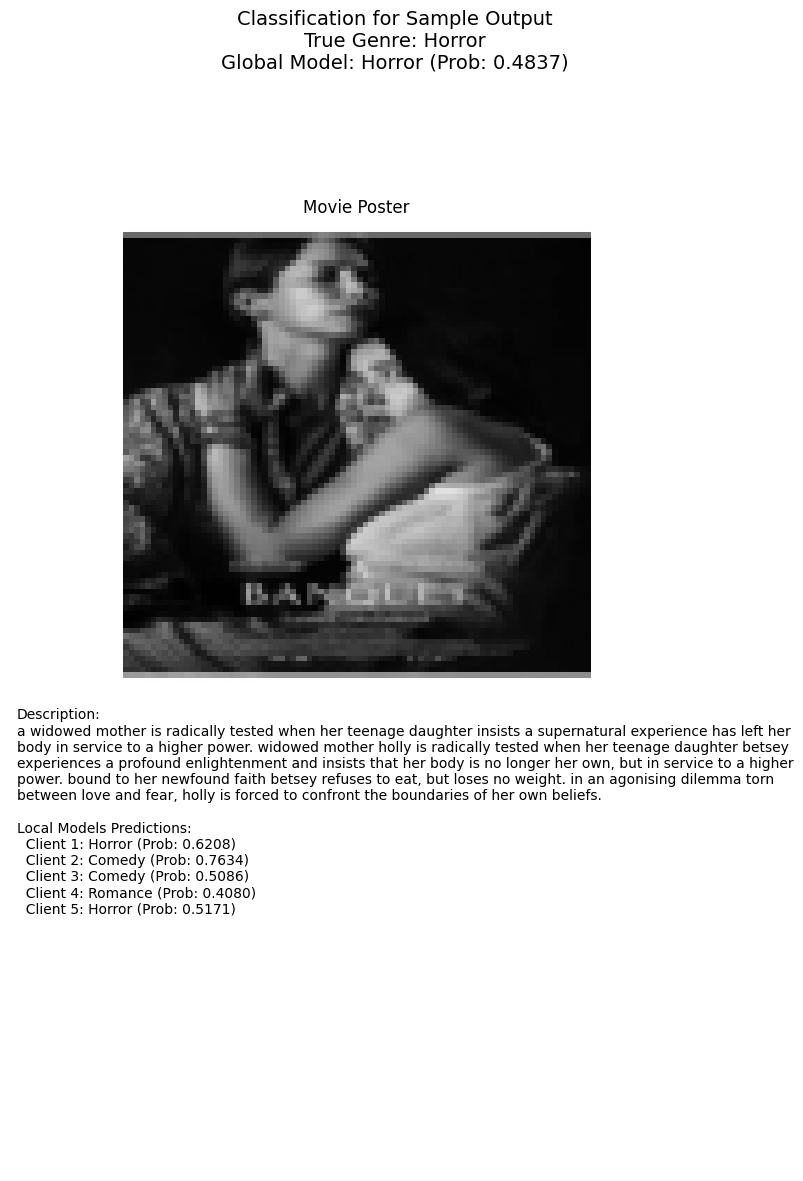

Final global model saved to /content/final_global_model_pytorch_fl.pth


In [22]:
# ... (rest of your existing imports) ...
import transformers # NEW: Import transformers library

# --- Configuration and Hyperparameters ---
# ... (existing image_size, max_sequence_length, embedding_dim, DEPTH, L2_REG_LAMBDA) ...

# --- BERT Specific Parameters ---
# The hidden_size of DistilBERT's last layer. This will be the output_features of our BERT encoder.
BERT_OUTPUT_DIM = 768 # DistilBERT's default hidden size
# This means your fc1 input in MultimodalClassificationNetwork will now be (64 + 768)

# You will likely need to significantly reduce BATCH_SIZE for BERT.
BATCH_SIZE = 4 # Start with a very small batch size, e.g., 4 or even 2, 1.

# ... (rest of your existing code for NUM_CLASSES, FL parameters, device config) ...

# --- Data Loading and Preprocessing ---
# ... (existing image_descriptions loading) ...

# --- NEW: BERT Tokenizer and Embedding Replacement ---
from transformers import AutoTokenizer, AutoModel

# Load a pre-trained BERT-like tokenizer and model
# Using DistilBERT as it's smaller than BERT-base
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# We'll use this tokenizer globally, similar to how word_to_idx was used.

# The `vocab_size` will now be tokenizer.vocab_size for the embedding layer,
# but we won't directly use nn.Embedding in DescriptionEncoderBERT.
# We pass vocab_size to MultimodalClassificationNetwork for consistency, but
# DescriptionEncoderBERT doesn't use it directly.

# --- REVISED: DescriptionEncoderBERT (instead of DescriptionEncoderLSTM) ---
class DescriptionEncoderBERT(nn.Module):
    def __init__(self, bert_model_name="distilbert-base-uncased", output_features=64, freeze_bert=True):
        super(DescriptionEncoderBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        # Add a linear layer to map BERT's output (typically 768 for DistilBERT) to 64 features
        self.fc_out = nn.Linear(self.bert.config.hidden_size, output_features)
        self.relu = nn.ReLU() # Consistent with other encoder outputs

    def forward(self, input_ids, attention_mask):
        # BERT takes input_ids and attention_mask
        # output.last_hidden_state: (batch_size, sequence_length, hidden_size)
        # output.pooler_output: (batch_size, hidden_size) - this is the [CLS] token's pooled representation
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :] # Get the [CLS] token's embedding (first token)

        x = self.fc_out(pooled_output)
        x = self.relu(x)
        return x # This will be (batch_size, 64)


# --- Data Preprocessing Adjustments (replacing manual tokenization) ---
# Remove the old `word_to_idx`, `idx_counter`, `sequences`, `padded_sequences` logic.
# The tokenizer will handle this now.

# Update `load_data_pytorch` (no change needed in its structure, but descriptions
# will be passed to tokenizer later)
# `data_descriptions` will now store the tokenized inputs directly.

# --- Modify the main data loading flow ---
# Replace this section:
# print("Processing descriptions...")
# all_descriptions = [image_descriptions[id] for id in data_ids]
# ... (old word_to_idx, sequence, padded_sequences logic) ...
# data_descriptions = torch.tensor(padded_sequences, dtype=torch.long)
# print("Descriptions processed.")

# With this:
print("Processing descriptions with BERT tokenizer...")
all_descriptions = [image_descriptions[id] for id in data_ids]

# Tokenize all descriptions at once
tokenized_outputs = tokenizer(
    all_descriptions,
    max_length=max_sequence_length, # Use the defined max_sequence_length
    padding='max_length',
    truncation=True,
    return_tensors="pt" # Return PyTorch tensors
)

data_descriptions_input_ids = tokenized_outputs['input_ids']
data_descriptions_attention_mask = tokenized_outputs['attention_mask']

print("Descriptions processed with BERT tokenizer.")
print(f"Tokenized input_ids shape: {data_descriptions_input_ids.shape}")
print(f"Attention mask shape: {data_descriptions_attention_mask.shape}")


# --- Update Dataset Class for BERT inputs ---
class MovieClassificationDataset(Dataset):
    def __init__(self, images, description_input_ids, description_attention_mask, labels):
        self.images = images
        self.description_input_ids = description_input_ids
        self.description_attention_mask = description_attention_mask
        self.labels = labels
        self.num_samples = len(images)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Return image, BERT input_ids, BERT attention_mask, and label
        return self.images[idx], \
               self.description_input_ids[idx], \
               self.description_attention_mask[idx], \
               torch.tensor(self.labels[idx], dtype=torch.long)

# --- Update Model Class to use BERT encoder and handle new inputs ---
# Replace MultimodalClassificationNetwork
class MultimodalClassificationNetwork(nn.Module):
    def __init__(self, input_size, depth, vocab_size, embedding_dim, lstm_hidden_dim=64, num_classes=4):
        super(MultimodalClassificationNetwork, self).__init__()
        self.image_encoder = ResNet50ImageEncoder(output_features=64) # Outputs 64 features
        # Use the new BERT encoder here
        self.description_encoder = DescriptionEncoderBERT(output_features=64) # Outputs 64 features

        # Concat features from ONE image (64) and ONE description (64) = 128
        self.fc1 = nn.Linear(64 + 64, 64)
        self.bn = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.dropout_final = nn.Dropout(p=0.5, inplace=False)
        self.output_layer = nn.Linear(64, num_classes)

    def forward(self, img, input_ids, attention_mask): # New: takes BERT inputs
        feature_vector_img = self.image_encoder(img)
        feature_vector_desc = self.description_encoder(input_ids, attention_mask) # Pass BERT inputs

        concat_features = torch.cat((feature_vector_img, feature_vector_desc), dim=1)

        x = self.fc1(concat_features)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout_final(x)
        output = self.output_layer(x)
        return output

# --- Update DescriptionEncoderLSTM (it's replaced, but keep for structure if needed) ---
# You can comment out or remove DescriptionEncoderLSTM now, as DescriptionEncoderBERT replaces it.
# class DescriptionEncoderLSTM(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, lstm_hidden_dim):
#         super(DescriptionEncoderLSTM, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.dropout_emb = nn.Dropout(p=0.2, inplace=False)
#         self.lstm = nn.LSTM(embedding_dim, 64, batch_first=True, dropout=0.2)
#
#     def forward(self, x):
#         x = self.embedding(x)
#         x = self.dropout_emb(x)
#         _, (hidden, _) = self.lstm(x)
#         return hidden.squeeze(0)


# --- Update Data Splitting for Clients (to use new description data) ---
# Replace this section:
# train_images_all = data_images[train_indices]
# train_descriptions_all = data_descriptions[train_indices]
# train_labels_all = data_labels[train_indices]
# ...
# X_val_global = data_images[global_val_indices]
# desc_val_global = data_descriptions[global_val_indices]
# y_val_global = data_labels[global_val_indices]
# ... etc.

# With this:
train_images_all = data_images[train_indices]
train_descriptions_input_ids_all = data_descriptions_input_ids[train_indices]
train_descriptions_attention_mask_all = data_descriptions_attention_mask[train_indices]
train_labels_all = data_labels[train_indices]

# Global validation set
X_val_global = data_images[global_val_indices]
desc_val_global_input_ids = data_descriptions_input_ids[global_val_indices]
desc_val_global_attention_mask = data_descriptions_attention_mask[global_val_indices]
y_val_global = data_labels[global_val_indices]

# Global final test set
X_test_global = data_images[global_test_indices_final]
desc_test_global_input_ids = data_descriptions_input_ids[global_test_indices_final]
desc_test_global_attention_mask = data_descriptions_attention_mask[global_test_indices_final]
y_test_global = data_labels[global_test_indices_final]


# --- Update Dataset Instantiation for Clients ---
# Replace this loop:
# client_dataset = MovieClassificationDataset(client_images_subset, client_descriptions_subset, client_labels_subset)
# With this:
client_datasets = []
for i, indices in enumerate(client_train_indices):
    client_images_subset = train_images_all[indices]
    client_descriptions_input_ids_subset = train_descriptions_input_ids_all[indices]
    client_descriptions_attention_mask_subset = train_descriptions_attention_mask_all[indices]
    client_labels_subset = train_labels_all[indices]

    client_dataset = MovieClassificationDataset(
        client_images_subset,
        client_descriptions_input_ids_subset, # Pass input_ids
        client_descriptions_attention_mask_subset, # Pass attention_mask
        client_labels_subset
    )
    client_datasets.append(client_dataset)
    print(f"Client {i+1} has {len(client_dataset)} samples.")

# --- Update Global Val/Test Dataset Instantiation ---
# Replace:
# global_val_dataset = MovieClassificationDataset(X_val_global, desc_val_global, y_val_global)
# With:
global_val_dataset = MovieClassificationDataset(X_val_global, desc_val_global_input_ids, desc_val_global_attention_mask, y_val_global)
global_val_loader = DataLoader(global_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Global Validation set has {len(global_val_dataset)} samples.")

# Replace:
# global_test_dataset_final = MovieClassificationDataset(X_test_global, desc_test_global, y_test_global)
# With:
global_test_dataset_final = MovieClassificationDataset(X_test_global, desc_test_global_input_ids, desc_test_global_attention_mask, y_test_global)
global_test_loader_final = DataLoader(global_test_dataset_final, batch_size=BATCH_SIZE, shuffle=False)
print(f"Global Final Test set has {len(global_test_dataset_final)} samples.")


# --- Update Client Class (to handle BERT inputs) ---
# Replace Client class
class Client:
    def __init__(self, client_id, dataset, model_params):
        self.id = client_id
        self.local_model = MultimodalClassificationNetwork(
            input_size=image_size[0],
            depth=DEPTH,
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            lstm_hidden_dim=64, # This parameter is still passed but ignored by BERT encoder
            num_classes=NUM_CLASSES
        ).to(device)
        self.local_model.load_state_dict(model_params)
        self.data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        self.optimizer = optim.Adam(self.local_model.parameters(), lr=0.001, weight_decay=L2_REG_LAMBDA)
        self.criterion = nn.CrossEntropyLoss()

    def receive_global_model(self, global_model_params):
        self.local_model.load_state_dict(global_model_params)
        self.optimizer = optim.Adam(self.local_model.parameters(), lr=0.001, weight_decay=L2_REG_LAMBDA)

    def train_local(self):
        self.local_model.train()
        max_batches_per_local_epoch = 100 # Adjust this based on client data size and desired local training.

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

        for epoch in range(LOCAL_EPOCHS):
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            num_batches_processed = 0

            # Inputs are now img, input_ids, attention_mask, labels
            for i, (img, input_ids, attention_mask, labels) in enumerate(self.data_loader):
                if num_batches_processed >= max_batches_per_local_epoch:
                    break

                img, input_ids, attention_mask, labels = img.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)

                self.optimizer.zero_grad()
                outputs = self.local_model(img, input_ids, attention_mask) # Pass all BERT inputs
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
                num_batches_processed += 1

            if total_train > 0:
                epoch_loss = running_loss / total_train
                epoch_acc = correct_train / total_train
                print(f"  Client {self.id} - Local Epoch {epoch+1}/{LOCAL_EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
            else:
                print(f"  Client {self.id} - Local Epoch {epoch+1}/{LOCAL_EPOCHS}, No training data processed for this epoch.")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

        return self.local_model.state_dict(), epoch_loss, epoch_acc

# --- Server Logic (Federated Averaging) ---
# Only need to change evaluate_global_model to handle BERT inputs
def evaluate_global_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

        max_eval_batches = 100
        num_batches_evaluated = 0

        # Inputs are now img, input_ids, attention_mask, labels
        for img, input_ids, attention_mask, labels in data_loader:
            if num_batches_evaluated >= max_eval_batches:
                break

            img, input_ids, attention_mask, labels = img.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(img, input_ids, attention_mask) # Pass all BERT inputs
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            num_batches_evaluated += 1

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

    if total == 0:
        return 0.0, 0.0

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


# --- Initialize Global Model (using MultimodalClassificationNetwork) ---
global_model = MultimodalClassificationNetwork(
    input_size=image_size[0],
    depth=DEPTH,
    vocab_size=vocab_size, # This is technically not used by BERT encoder
    embedding_dim=embedding_dim, # This is technically not used by BERT encoder
    lstm_hidden_dim=64, # This is technically not used by BERT encoder
    num_classes=NUM_CLASSES
).to(device)

clients = []
for i, dataset in enumerate(client_datasets):
    client = Client(i + 1, dataset, global_model.state_dict())
    clients.append(client)
print(f"Initialized {len(clients)} clients.")

# --- Federated Learning Training Loop ---
print("\n--- Starting Federated Learning Training ---")
best_global_val_loss = float('inf') # Use validation loss for early stopping / best model saving
global_model_save_path = '/content/best_global_model_pytorch_fl.pth'

# Lists to store metrics for plotting
global_history_val_loss = []
global_history_val_accuracy = []
global_history_test_loss = []
global_history_test_accuracy = []
clients_history_loss = {f'Client {i+1}': [] for i in range(len(client_datasets))}
clients_history_accuracy = {f'Client {i+1}': [] for i in range(len(client_datasets))}


if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

for round_num in range(COMMUNICATION_ROUNDS):
    print(f"\nCommunication Round {round_num + 1}/{COMMUNICATION_ROUNDS}")

    for client in clients:
        client.receive_global_model(global_model.state_dict())

    client_updates = []
    for idx, client in enumerate(clients):
        print(f"  Client {client.id} starting local training...")
        updated_state_dict, local_loss, local_acc = client.train_local()
        client_updates.append(updated_state_dict)
        clients_history_loss[f'Client {client.id}'].append(local_loss)
        clients_history_accuracy[f'Client {client.id}'].append(local_acc)

    print("Aggregating client models...")
    aggregated_state_dict = federated_average(client_updates)
    global_model.load_state_dict(aggregated_state_dict)
    print("Global model updated.")

    # Evaluate global model on Validation set
    val_loss_round, val_acc_round = evaluate_global_model(global_model, global_val_loader, nn.CrossEntropyLoss())
    print(f"Global Model - Validation Loss: {val_loss_round:.4f}, Validation Accuracy: {val_acc_round:.4f}")

    # Evaluate global model on Final Test set
    test_loss_round, test_acc_round = evaluate_global_model(global_model, global_test_loader_final, nn.CrossEntropyLoss())
    print(f"Global Model - Final Test Loss: {test_loss_round:.4f}, Final Test Accuracy: {test_acc_round:.4f}")

    # Store global metrics for plotting
    global_history_val_loss.append(val_loss_round)
    global_history_val_accuracy.append(val_acc_round)
    global_history_test_loss.append(test_loss_round)
    global_history_test_accuracy.append(test_acc_round)

    # Use validation loss for best model saving
    if val_loss_round < best_global_val_loss:
        best_global_val_loss = val_loss_round
        torch.save(global_model.state_dict(), global_model_save_path)
        print(f"Best global model saved with validation loss: {best_global_val_loss:.4f}")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

print("\n--- Federated Learning Training Finished ---")

# --- Final Evaluation (on best saved model) ---
if os.path.exists(global_model_save_path):
    global_model.load_state_dict(torch.load(global_model_save_path))
    print(f"Loaded best global model from {global_model_save_path}")
else:
    print("No best global model saved. Using the last trained global model.")

final_val_loss, final_val_accuracy = evaluate_global_model(global_model, global_val_loader, nn.CrossEntropyLoss())
final_test_loss, final_test_accuracy = evaluate_global_model(global_model, global_test_loader_final, nn.CrossEntropyLoss())
print(f"\nFinal Global Model Performance (Best Model):")
print(f"Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.4f}")


# --- Plotting Training History (Global Val/Test vs Clients Local Train) ---
print("\n--- Generating Plots ---")
rounds = range(1, COMMUNICATION_ROUNDS + 1)

plt.figure(figsize=(16, 7))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(rounds, global_history_val_loss, marker='o', linestyle='-', label='Global Model (Validation)', color='blue', linewidth=2)
plt.plot(rounds, global_history_test_loss, marker='x', linestyle='--', label='Global Model (Final Test)', color='red', linewidth=2)
for client_id, losses in clients_history_loss.items():
    plt.plot(rounds, losses, linestyle=':', alpha=0.6, label=f'{client_id} (Local Train)')
plt.title('Loss over Communication Rounds')
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(rounds, global_history_val_accuracy, marker='o', linestyle='-', label='Global Model (Validation)', color='blue', linewidth=2)
plt.plot(rounds, global_history_test_accuracy, marker='x', linestyle='--', label='Global Model (Final Test)', color='red', linewidth=2)
for client_id, accuracies in clients_history_accuracy.items():
    plt.plot(rounds, accuracies, linestyle=':', alpha=0.6, label=f'{client_id} (Local Train)')
plt.title('Accuracy over Communication Rounds')
plt.xlabel('Communication Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.tight_layout()
plt.show()

# --- Plotting a Sample Prediction Output (for multi-class classification) ---
print("\n--- Plotting a Sample Prediction Output ---")

if len(X_test_global) < 1:
    print("Not enough global test samples to plot a single prediction. Need at least 1 sample.")
else:
    np.random.seed(42) # For reproducibility of the sample output plot
    idx = np.random.choice(len(X_test_global), 1, replace=False)[0]

    img_display = X_test_global[idx].squeeze().cpu().numpy()

    desc_words = []
    # Reverse lookup for word_to_idx is correct
    reverse_word_map = {v: k for k, v in word_to_idx.items()}
    for token_id in desc_test_global[idx].cpu().numpy():
        if token_id == 0: # Pad token is 0
            break
        desc_words.append(reverse_word_map.get(token_id, '<unk>')) # Use .get with <unk> for robustness
    desc_full_text = ' '.join(desc_words[:100]) + '...' if len(desc_words) > 100 else ' '.join(desc_words)


    img_model = X_test_global[idx].unsqueeze(0).to(device)
    desc_model_input_ids = desc_test_global[idx].unsqueeze(0).to(device)
    desc_model_attention_mask = torch.ones_like(desc_model_input_ids).to(device) # Create attention mask for single sample

    true_label_id = y_test_global[idx]
    reverse_label_map = {v: k for k, v in class_to_label.items()}
    true_label_text = reverse_label_map.get(true_label_id, 'Unknown')


    global_model.eval()
    with torch.no_grad():
        outputs_global = global_model(img_model, desc_model_input_ids, desc_model_attention_mask) # Pass attention mask
        predicted_prob_raw_global = torch.softmax(outputs_global, dim=1)
        predicted_prob_value_global, predicted_class_id_global = torch.max(predicted_prob_raw_global, 1)

    predicted_class_text_global = reverse_label_map.get(predicted_class_id_global.item(), 'Unknown')
    predicted_prob_for_class_global = predicted_prob_value_global.item()

    # --- Predictions from Local Models ---
    local_predictions_text = []
    # Recreate local models for prediction if they are not stored directly, or load from saved state dicts
    # In a real FL setup, you wouldn't load all client models to the server.
    # For this simulation, we access the 'clients' objects which hold their local_model.
    for client_obj in clients:
        client_model = client_obj.local_model
        client_model.eval()
        with torch.no_grad():
            outputs_local = client_model(img_model, desc_model_input_ids, desc_model_attention_mask) # Pass attention mask
            predicted_prob_raw_local = torch.softmax(outputs_local, dim=1)
            predicted_prob_value_local, predicted_class_id_local = torch.max(predicted_prob_raw_local, 1)

        predicted_class_text_local = reverse_label_map.get(predicted_class_id_local.item(), 'Unknown')
        predicted_prob_for_class_local = predicted_prob_value_local.item()

        local_predictions_text.append(
            f"  Client {client_obj.id}: {predicted_class_text_local} (Prob: {predicted_prob_for_class_local:.4f})"
        )

    plt.figure(figsize=(8, 12))

    plt.subplot(2, 1, 1)
    plt.imshow(img_display, cmap='gray')
    plt.title('Movie Poster')
    plt.axis('off')

    plt.suptitle(f"Classification for Sample Output\n"
                 f"True Genre: {true_label_text}\n"
                 f"Global Model: {predicted_class_text_global} (Prob: {predicted_prob_for_class_global:.4f})",
                 fontsize=14, y=0.98)

    plt.subplot(2, 1, 2)
    desc_display_text = f"Description:\n{desc_full_text}\n\n"
    local_models_summary = "Local Models Predictions:\n" + "\n".join(local_predictions_text)
    full_text_to_display = desc_display_text + local_models_summary

    plt.text(0.01, 0.99, full_text_to_display,
             verticalalignment='top', horizontalalignment='left',
             fontsize=10, wrap=True)
    plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

torch.save(global_model.state_dict(), '/content/final_global_model_pytorch_fl.pth')
print("Final global model saved to /content/final_global_model_pytorch_fl.pth")